# MNIST with Keras

This notebook uses Keras, a high-level neural network system, to build a model capable of identifying hand-written digits (0 - 9) with high accuracy.

This MNIST database contains 70,000 pictures of digits. Each picture is stored as a matrix of 28 x 28 pixels, whose values represent how dark the pixel is on a scale of 0 to 255. We'll use 60,000 of these samples to train the model, then evaluate its accuracy by testing it on remaining 10,000 samples.

In [135]:
# Our model is a sequential stack of CNN layers
from keras.models import Sequential

# "Core" layers of Keras
from keras.layers import Dense, Dropout, Activation, Flatten

# CNN layers
from keras.layers import Convolution2D, MaxPooling2D

# Datasets and Utils
from keras.utils import np_utils
from keras.datasets import mnist

# Other
from collections import defaultdict
import os
from subprocess import call

# Numpy and Pandas
import pandas as pd
import numpy as np
np.random.seed(123)

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Input Data

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train (capital X for matrix) contains 60,000 train samples. <br>
y_train (lowercase for vector) is a 1D vector that identifies what digit is represented by the corresponding vector in X_train.

In [6]:
X_train.shape

(60000, 28, 28)

60,000 samples that are 28 x 28 pixels each. Let's plot one as an example

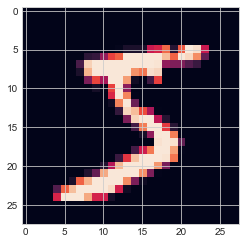

In [7]:
plt.imshow(X_train[0]);

### Preprocess Data

Tensorflow requires we declare a dimension for the _depth_ of the input image. A full-color image with 3 **RGB** channels would have a depth of 3. Our black and white pixel image has a depth of 1.

Transform the dataset from (n, width, height) to (n, width, height, depth)

In [8]:
num_train_samples, img_rows, img_cols = X_train.shape

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

# Input shape of a single image
input_shape = (img_rows, img_cols, 1)
X_train.shape

(60000, 28, 28, 1)

In [9]:
# Declare the types for our inputs
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize dataset to be between 0 and 1. MNIST uses 255 as a maximum value
print np.max(X_train)
X_train /= 255
X_test /= 255

255.0


### Preprocess Labels

In [10]:
print y_train.shape
y_train[:10]

(60000,)


array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

The data is in a typical format for machine learning. It is a list of labels, one for each samples in X_train. Keras requires we reshape the data into 10 distinct classes, one for each digit.

In [11]:
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [12]:
Y_train.shape

(60000, 10)

In [13]:
Y_train[:10]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

The first row corresponds to '5', the next row to '0', and the next row to '4', which matches our first array. This is typically called "One Hot Encoding", where _categorical_ features are turned into binary vectors of 0's and 1's.

### Define Model Architecture

In [14]:
model = Sequential()

In [15]:
model.add(Convolution2D(filters=28, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=(28,28, 1)))

Filters is an integer that represents the dimensionality of the output space. The kernel_size specifies the width and height of the 2D convolution window.

Add more layers to the model

In [16]:
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

The **Dropout** layer is an important method for regularizing the model to prevent overfitting. Explanation [here](https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning-And-why-is-it-claimed-to-be-an-effective-trick-to-improve-your-network).

MaxPooling2D is a way to reduce the number of parameters in our model by sliding a 2x2 pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter.

So far, for model parameters, we've added two Convolution layers. To complete our model architecture, let's add a fully connected layer and then the output layer:

In [17]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

For Dense layers, the first parameter is the output size of the layer. Keras automatically handles the connections between layers.

Note that the final layer has an output size of 10, corresponding to the 10 classes of digits.

Also note that the weights from the Convolution layers must be flattened (made 1-dimensional) before passing them to the fully connected Dense layer.

### Compile Model

Compiling the model just means specifying a loss function and optimizer

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fit Model on Training Data

In [19]:
%time
model.fit(X_train, Y_train, 
          batch_size=128, 
          epochs=12, 
          verbose=1,
          validation_data=(X_test, Y_test))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.15 µs
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 156s - loss: 0.2718 - acc: 0.9172 - val_loss: 0.0533 - val_acc: 0.9835
Epoch 2/12
60000/60000 [==============================] - 149s - loss: 0.0915 - acc: 0.9730 - val_loss: 0.0407 - val_acc: 0.9871
Epoch 3/12
60000/60000 [==============================] - 151s - loss: 0.0705 - acc: 0.9789 - val_loss: 0.0334 - val_acc: 0.9886
Epoch 4/12
60000/60000 [==============================] - 152s - loss: 0.0576 - acc: 0.9822 - val_loss: 0.0306 - val_acc: 0.9898
Epoch 5/12
60000/60000 [==============================] - 147s - loss: 0.0509 - acc: 0.9839 - val_loss: 0.0310 - val_acc: 0.9898
Epoch 6/12
60000/60000 [==============================] - 142s - loss: 0.0427 - acc: 0.9864 - val_loss: 0.0304 - val_acc: 0.9904
Epoch 7/12
60000/60000 [==============================] - 141s - loss: 0.0394 - acc: 0.9879 - val_loss: 0.0294 -

Score the model

In [20]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', round(loss, 4))
print('Test accuracy:', round(accuracy, 4))

('Test loss:', 0.0288)
('Test accuracy:', 0.9919)


### Closer Look

To understand what is evaluated by **Test Accuracy**, let's look at a single example from our X_test

In [21]:
index = 50
print y_test[50]

6


The 50th sample in our test set is for the number 6. Let's see what it looks like

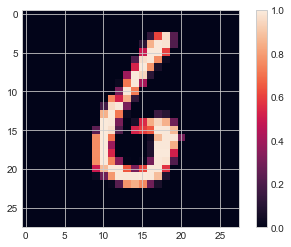

In [246]:
# Because our dimensions are 60.000, 28, 28, and 1, we select the 50th sample as follows:
# 50 for the 50th sample. ":" means all values, so all values for width and height, then 0 at the end for that dim.
plt.imshow(X_test[50,:,:,0]); plt.colorbar()

Plugging this sample into our model, it will give us confidence scores for how likely it thinks each number is

In [23]:
# I use the clunky syntax [50:51] to select a single sample but retain the dimensionality
# X_test[50] returns a (28 x 28 x 1) vector but our model requires an (n x 28 x 28 x 1) tensor
for i, j in zip(xrange(10), model.predict(X_test[50:51])[0]):
    print 'Digit: {}\t Probability: {}'.format(i, j)

Digit: 0	 Probability: 5.33506606948e-11
Digit: 1	 Probability: 1.05252590497e-12
Digit: 2	 Probability: 5.42265791799e-15
Digit: 3	 Probability: 4.29508926797e-14
Digit: 4	 Probability: 8.03828845933e-13
Digit: 5	 Probability: 2.32912604758e-08
Digit: 6	 Probability: 1.0
Digit: 7	 Probability: 1.90053968798e-18
Digit: 8	 Probability: 5.73982666952e-11
Digit: 9	 Probability: 2.73838954408e-15


Dope!

# Bonus Round

**Which digit is the most difficult to identify?**

In [123]:
# Build accuracy dataframe so we don't keep calling model.predict
%time
info = [list(model.predict(X_test[i:i+1])[0]) for i in xrange(len(X_test))]
df = pd.DataFrame.from_records(info)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 20 µs


In [124]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,3.753787e-15,2.349356e-11,9.115769e-13,3.120679e-10,1.050341e-14,6.655724e-15,9.248858e-20,1.000000e+00,5.607553e-13,4.918307e-11
1,4.554177e-12,1.369363e-06,9.999987e-01,2.014215e-13,7.748726e-14,2.138064e-17,6.389435e-14,9.508598e-14,3.183251e-14,6.755675e-17
2,2.491735e-09,9.999992e-01,1.601278e-07,2.628821e-10,3.296112e-07,7.724814e-09,3.782790e-07,2.729449e-08,1.294667e-08,2.028554e-09
3,1.000000e+00,5.709309e-11,4.118527e-10,5.217036e-12,6.314926e-12,2.917198e-11,1.213034e-08,4.777737e-11,1.775666e-10,1.081366e-09
4,4.819369e-13,1.084522e-11,3.986005e-13,6.932789e-16,9.999987e-01,4.927090e-14,1.877993e-12,2.610559e-12,2.405626e-11,1.340771e-06


Which number is guessed incorrectly most often?

In [57]:
%time
wrong_guess = defaultdict(int)
for row, answer in zip(df.iterrows(), y_test):
    index, guess = row
    if list(guess).index(max(guess)) != answer:
        wrong_guess[answer] += 1

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [125]:
for k, v in sorted(wrong_guess.iteritems()):
    print 'Digit: {}\t# wrong guesses: {}'.format(k, v)

Digit: 0	# wrong guesses: 4
Digit: 1	# wrong guesses: 7
Digit: 2	# wrong guesses: 7
Digit: 3	# wrong guesses: 5
Digit: 4	# wrong guesses: 12
Digit: 5	# wrong guesses: 7
Digit: 6	# wrong guesses: 13
Digit: 7	# wrong guesses: 11
Digit: 8	# wrong guesses: 6
Digit: 9	# wrong guesses: 9


Which image has the lowest confidence when guessed?

In [88]:
%time
confidence = defaultdict(list)
for guess, answer in zip(df.max(axis=1), y_test):
    confidence[answer].append(guess)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 14.1 µs


plot kernel densities

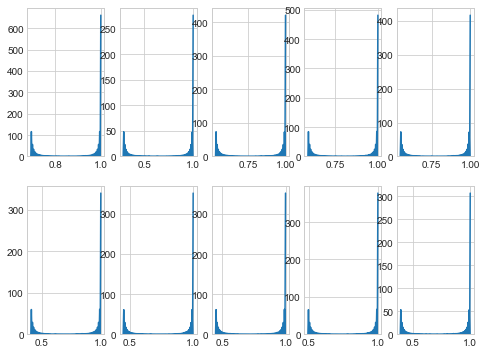

In [89]:
f, ax = plt.subplots(2, 5, figsize=(8, 6))
ax = ax.flatten()
for i in xrange(len(confidence)):
    sns.kdeplot(confidence[i], ax=ax[i])

All digits have roughly the same distribution of accuracy

### Which picture was the hardest to guess?

The real answer is 1
The model guessed:
Digit: 0	Prob: 0.000462176714791
Digit: 1	Prob: 0.266207426786
Digit: 2	Prob: 0.230069696903
Digit: 3	Prob: 0.28124538064
Digit: 4	Prob: 7.24997880752e-05
Digit: 5	Prob: 4.94508858537e-05
Digit: 6	Prob: 4.18177432948e-06
Digit: 7	Prob: 0.0360736660659
Digit: 8	Prob: 0.185164600611
Digit: 9	Prob: 0.000650945585221


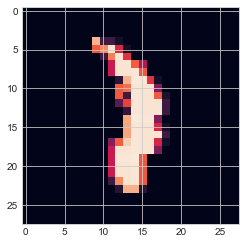

In [119]:
index = df.max(axis=1).idxmin()
print 'The real answer is {}'.format(y_test[index])
plt.imshow(X_test[index, :, :, 0]);
print 'The model guessed:'
for i, j in enumerate(df.iloc[index]):
    print 'Digit: {}\tProb: {}'.format(i, j)

That is definitely an ugly 1.

# Super Extra Bonus Round
* Upload and classify your own digit! (not that kind Aaron)

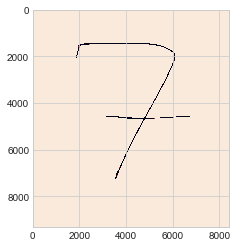

In [209]:
from scipy.misc import imread
im = imread('data/7.png', flatten=True)
plt.imshow(im)

We'll have to resize the image in order to use it with our model

In [297]:
def resize_image(img_path, resize='28x28', grayscale=True, output_prefix='resized.'):
    """
    Resizes and image using ImageMagick

    :param str img_path: Path to image
    :param str resize: Resize w x h in pixels
    :param bool grayscale: If True, image will be greyscale
    :param str output_prefix: Prefix for output image
    :return: Output path
    :rtype: str
    """
    dirname, name = os.path.split(img_path)

    params = ['convert', img_path,
              '-resize', resize + '^',
              '-gravity', 'center',
              '-extent', resize]

    if grayscale:
        params.extend(['-type', 'Grayscale'])

    output_path = os.path.join(dirname, output_prefix + name)
    call(params + [output_path])

    return output_path

Now we'll write a function to resize our input, read, normalize, plot, and predict an image

In [312]:
def plot_and_predict(img_path, resize=True):
    # Read image
    img_path = resize_image(img_path) if resize else img_path
    im = imread(img_path, flatten=True)
    
    # Normalize ... this was annoying as fuck
    im = im * 1.0  # Dtype needs to be a float for next operation
    im = np.abs(im - 255)  # White is max at 255, so subtract
    im /= np.max(im)  # Normalize between 0 and 1
    im[im > 0.25] = 1  # Strongly weights
    
    # Plot
    plt.imshow(im); plt.colorbar()
    
    # Predict
    im = im.reshape(1, img_rows, img_cols, 1)
    for i, j in enumerate(model.predict(im)[0]):
        print 'Digit: {}\t Prob: {}'.format(i, j)

Digit: 0	 Prob: 3.19437617871e-15
Digit: 1	 Prob: 6.54859916294e-11
Digit: 2	 Prob: 0.996887862682
Digit: 3	 Prob: 0.00271940696985
Digit: 4	 Prob: 6.92297219551e-10
Digit: 5	 Prob: 4.3200417744e-13
Digit: 6	 Prob: 1.27661900487e-14
Digit: 7	 Prob: 0.000392564368667
Digit: 8	 Prob: 1.71787974068e-07
Digit: 9	 Prob: 5.29726544747e-14


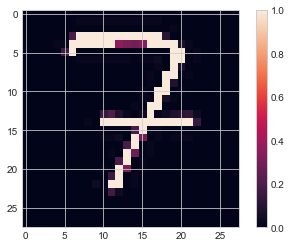

In [307]:
plot_and_predict('data/7.png')

Damn, guess I draw 7s in a way that is different from all participants in the training set. What about another number?

Digit: 0	 Prob: 5.6514726926e-11
Digit: 1	 Prob: 5.41928307785e-12
Digit: 2	 Prob: 3.84828080513e-09
Digit: 3	 Prob: 2.66284789774e-08
Digit: 4	 Prob: 1.16556282109e-14
Digit: 5	 Prob: 2.2449428343e-06
Digit: 6	 Prob: 1.62227550837e-10
Digit: 7	 Prob: 2.57001017689e-12
Digit: 8	 Prob: 0.999997735023
Digit: 9	 Prob: 1.92036490876e-11


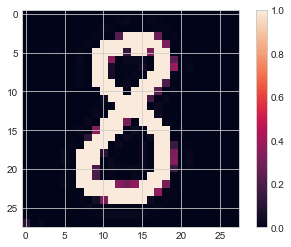

In [311]:
plot_and_predict('data/8.png')

Nice! Correctly guessed with a very high confidence.